In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from time import time
from keras.layers import Dense, Input,Conv1D, MaxPooling1D, Flatten, Embedding, Reshape, UpSampling1D, LeakyReLU
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import pickle

from scipy import special

Using TensorFlow backend.


In [2]:
P = np.array([
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
    [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
], dtype='int')

In [3]:
def custom_activation(x):
    return 1 / (1 + keras.backend.exp(10*(-x)))

In [4]:
def syndrome_decoding(codes):
    with open('syndrome.pickle', 'rb') as syn:
        syndrome = pickle.load(syn)
        
    H = np.concatenate((np.eye(11, dtype="int"), P.T), axis=1)
    fix_code = []
    for code in codes:
        code_syndrome = tuple(np.dot(code, H.T) % 2)
        error_code = syndrome[code_syndrome]
        fix_code.append((code + error_code) % 2)
    return np.array(fix_code)

In [5]:
def awgn(x_input, reqSNR):
    sig_power = 1
#     reqSNR = np.sqrt(2*10**(reqSNR / 10))
    
    noise_power = np.sqrt(sig_power / (2 * reqSNR))
    
    noise = noise_power * np.random.normal(size = x_input.shape)
    
    return x_input + noise

In [6]:
def mld_func(x_noisy):
    codeword = np.loadtxt('input.txt')

    for i in range(x_noisy.shape[0]):
        check = np.dot(x_noisy[i, :], codeword.T)
        max_check = np.max(check)
        index = np.where(check == max_check)[0][0]
        if i == 0:
            mld_code = codeword[index, :]
        else :
            mld_code = np.vstack((mld_code, codeword[index, :]))
 
    return np.where(mld_code < 0, 1, 0)

In [7]:
model_BER = np.zeros(11)
model_1_BER = np.zeros(11)
model_2_BER = np.zeros(11)
model_3_BER = np.zeros(11)
model_4_BER = np.zeros(11)
model_5_BER = np.zeros(11)
model_6_BER = np.zeros(11)
model_7_BER = np.zeros(11)
model_8_BER = np.zeros(11)

In [8]:
model = load_model('model_relu_softstep_0.4.h5', custom_objects={'custom_activation':custom_activation})
model_1 = load_model('model_p5_v2.h5')
model_2 = load_model('model_p6.h5')
model_3 = load_model('model_p7.h5')
model_4 = load_model('model_p8.h5')
model_5 = load_model('model_p5_v2.h5')
model_6 = load_model('model_p6.h5')
model_7 = load_model('model_p7.h5')
model_8 = load_model('model_p8.h5')

In [9]:
file_buffer = 'result/model_result.txt'
model_f = open(file_buffer, 'w')

file_buffer = 'result/model_1_result.txt'
model_1_f = open(file_buffer, 'w')

file_buffer = 'result/model_2_result.txt'
model_2_f = open(file_buffer, 'w')

file_buffer = 'result/model_3_result.txt'
model_3_f = open(file_buffer, 'w')

file_buffer = 'result/model_4_result.txt'
model_4_f = open(file_buffer, 'w')

file_buffer = 'result/model_5_result.txt'
model_5_f = open(file_buffer, 'w')

file_buffer = 'result/model_6_result.txt'
model_6_f = open(file_buffer, 'w')

file_buffer = 'result/model_7_result.txt'
model_7_f = open(file_buffer, 'w')

file_buffer = 'result/model_8_result.txt'
model_8_f = open(file_buffer, 'w')

for i in range(0, 11):
    total_model_BER = 0
    total_model_1_BER = 0
    total_model_2_BER = 0
    total_model_3_BER = 0
    total_model_4_BER = 0
    total_model_5_BER = 0
    total_model_6_BER = 0
    total_model_7_BER = 0
    total_model_8_BER = 0

    for j in range(1):
        Eb_No = 10**(i/10)
        Es_No = Eb_No * (12/23)
    
        m = np.random.randint(2, size=(10**6, 12))
        G= np.concatenate((P, np.eye(12, dtype="int")), axis=1)
        x_test = np.dot(m, G) % 2
        x_test = np.where(x_test > 0, -1, 1)
    
        x_test_noisy = awgn(x_test, Es_No)
        
        x_input = (x_test_noisy + 1) / 2
    
        #auto encoding start
        model_decoded_codes = model.predict(x_input, verbose=1)
        model_1_decoded_codes = model_1.predict(x_test_noisy, verbose=1)
        model_2_decoded_codes = model_2.predict(x_test_noisy, verbose=1)
        model_3_decoded_codes = model_3.predict(x_test_noisy, verbose=1)
        model_4_decoded_codes = model_4.predict(x_test_noisy, verbose=1)
        model_5_decoded_codes = model_5.predict(x_test_noisy, verbose=1)
        model_6_decoded_codes = model_6.predict(x_test_noisy, verbose=1)
        model_7_decoded_codes = model_7.predict(x_test_noisy, verbose=1)
        model_8_decoded_codes = model_8.predict(x_test_noisy, verbose=1)
    
        model_decoded_codes = np.where(model_decoded_codes < 0.5, 1, 0)   
        model_decoded_codes = np.reshape(model_decoded_codes, (x_input.shape[0], 23))
        
        model_1_decoded_codes = np.where(model_1_decoded_codes < 0, 1, 0)   
        model_1_decoded_codes = np.reshape(model_1_decoded_codes, (x_input.shape[0], 23))
        
        model_2_decoded_codes = np.where(model_2_decoded_codes < 0, 1, 0)   
        model_2_decoded_codes = np.reshape(model_2_decoded_codes, (x_input.shape[0], 23))
        
        model_3_decoded_codes = np.where(model_3_decoded_codes < 0, 1, 0)   
        model_3_decoded_codes = np.reshape(model_3_decoded_codes, (x_input.shape[0], 23))

        model_4_decoded_codes = np.where(model_4_decoded_codes < 0, 1, 0)   
        model_4_decoded_codes = np.reshape(model_4_decoded_codes, (x_input.shape[0], 23))
        
        model_5_decoded_codes = np.where(model_5_decoded_codes < 0, 1, 0)   
        model_5_decoded_codes = np.reshape(model_5_decoded_codes, (x_input.shape[0], 23))
        
        model_6_decoded_codes = np.where(model_6_decoded_codes < 0, 1, 0)   
        model_6_decoded_codes = np.reshape(model_6_decoded_codes, (x_input.shape[0], 23))
        
        model_7_decoded_codes = np.where(model_7_decoded_codes < 0, 1, 0)   
        model_7_decoded_codes = np.reshape(model_7_decoded_codes, (x_input.shape[0], 23))
        
        model_8_decoded_codes = np.where(model_8_decoded_codes < 0, 1, 0)   
        model_8_decoded_codes = np.reshape(model_8_decoded_codes, (x_input.shape[0], 23))
        
        #syndrome start
        model_fix_code = syndrome_decoding(model_decoded_codes)
        model_1_fix_code = syndrome_decoding(model_1_decoded_codes)
        model_2_fix_code = syndrome_decoding(model_2_decoded_codes)
        model_3_fix_code = syndrome_decoding(model_3_decoded_codes)
        model_4_fix_code = syndrome_decoding(model_4_decoded_codes)
#         model_layer_5_fix_code = syndrome_decoding(model_layer_5_decoded_codes)
#         model_layer_7_fix_code = syndrome_decoding(model_layer_7_decoded_codes)

        model_count = ((m + model_fix_code[:,11:])%2).sum()
        model_1_count = ((m + model_1_fix_code[:,11:])%2).sum()
        model_2_count = ((m + model_2_fix_code[:,11:])%2).sum()
        model_3_count = ((m + model_3_fix_code[:,11:])%2).sum()
        model_4_count = ((m + model_4_fix_code[:,11:])%2).sum()
        model_5_count = ((m + model_5_decoded_codes[:,11:])%2).sum()
        model_6_count = ((m + model_6_decoded_codes[:,11:])%2).sum()
        model_7_count = ((m + model_7_decoded_codes[:,11:])%2).sum()
        model_8_count = ((m + model_8_decoded_codes[:,11:])%2).sum()

        total_model_BER += model_count / (m.shape[0] * m.shape[1])
        total_model_1_BER += model_1_count / (m.shape[0] * m.shape[1])
        total_model_2_BER += model_2_count / (m.shape[0] * m.shape[1])
        total_model_3_BER += model_3_count / (m.shape[0] * m.shape[1])
        total_model_4_BER += model_4_count / (m.shape[0] * m.shape[1])
        total_model_5_BER += model_5_count / (m.shape[0] * m.shape[1])
        total_model_6_BER += model_6_count / (m.shape[0] * m.shape[1])
        total_model_7_BER += model_7_count / (m.shape[0] * m.shape[1])
        total_model_8_BER += model_8_count / (m.shape[0] * m.shape[1])
    
    model_BER[i] = total_model_BER/1
    model_1_BER[i] = total_model_1_BER/1
    model_2_BER[i] = total_model_2_BER/1
    model_3_BER[i] = total_model_3_BER/1
    model_4_BER[i] = total_model_4_BER/1
    model_5_BER[i] = total_model_5_BER/1
    model_6_BER[i] = total_model_6_BER/1
    model_7_BER[i] = total_model_7_BER/1
    model_8_BER[i] = total_model_8_BER/1

    write_buffer = 'Eb_No, %f, ' %(i)
    model_f.write(write_buffer)
    model_1_f.write(write_buffer)
    model_2_f.write(write_buffer)
    model_3_f.write(write_buffer)
    model_4_f.write(write_buffer)
    model_5_f.write(write_buffer)
    model_6_f.write(write_buffer)
    model_7_f.write(write_buffer)
    model_8_f.write(write_buffer)

    write_buffer = 'BER, %.10f\n' % (model_BER[i])
    model_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_1_BER[i])
    model_1_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_2_BER[i])
    model_2_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_3_BER[i])
    model_3_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_4_BER[i])
    model_4_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_5_BER[i])
    model_5_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_6_BER[i])
    model_6_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_7_BER[i])
    model_7_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (model_8_BER[i])
    model_8_f.write(write_buffer)
    
model_f.close()
model_1_f.close()
model_2_f.close()
model_3_f.close()
model_4_f.close()
model_5_f.close()
model_6_f.close()
model_7_f.close()
model_8_f.close()

1000000/1000000 [==============================] - 64s 64us/step


In [10]:
bpsk_BER = np.zeros(11)
for i in range(0,11):
    bpsk_BER[i] = 0.5 * special.erfc((np.sqrt(10**(i/10))))

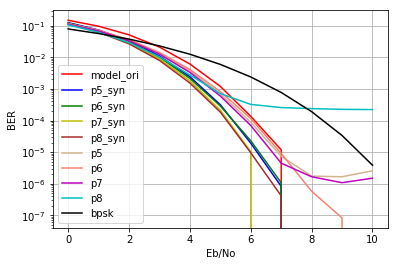

In [11]:
x = np.array(range(0, 11))

plt.semilogy(x,model_BER, label='model_ori', color='r')
plt.semilogy(x,model_1_BER, label='p5_syn', color='b')
plt.semilogy(x,model_2_BER, label='p6_syn', color='g')
plt.semilogy(x,model_3_BER, label='p7_syn', color='y')
plt.semilogy(x,model_4_BER, label='p8_syn', color='brown')
plt.semilogy(x,model_5_BER, label='p5', color='tan')
plt.semilogy(x,model_6_BER, label='p6', color='salmon')
plt.semilogy(x,model_7_BER, label='p7', color='m')
plt.semilogy(x,model_8_BER, label='p8', color='c')

plt.semilogy(x,bpsk_BER, label='bpsk', color='k')


plt.xlabel('Eb/No')
plt.ylabel('BER')

plt.legend()
plt.grid(True)
plt.show()